⏳ Memuat data dan model...
📊 Menggunakan 2000 sampel data...
🧠 Memuat Model AI...
⚡ Sedang meng-encode vektor...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

🏷️  Memprediksi label cluster...
📉 Sedang menjalankan t-SNE (mengubah ke 2D)...
🎨 Sedang menggambar grafik...


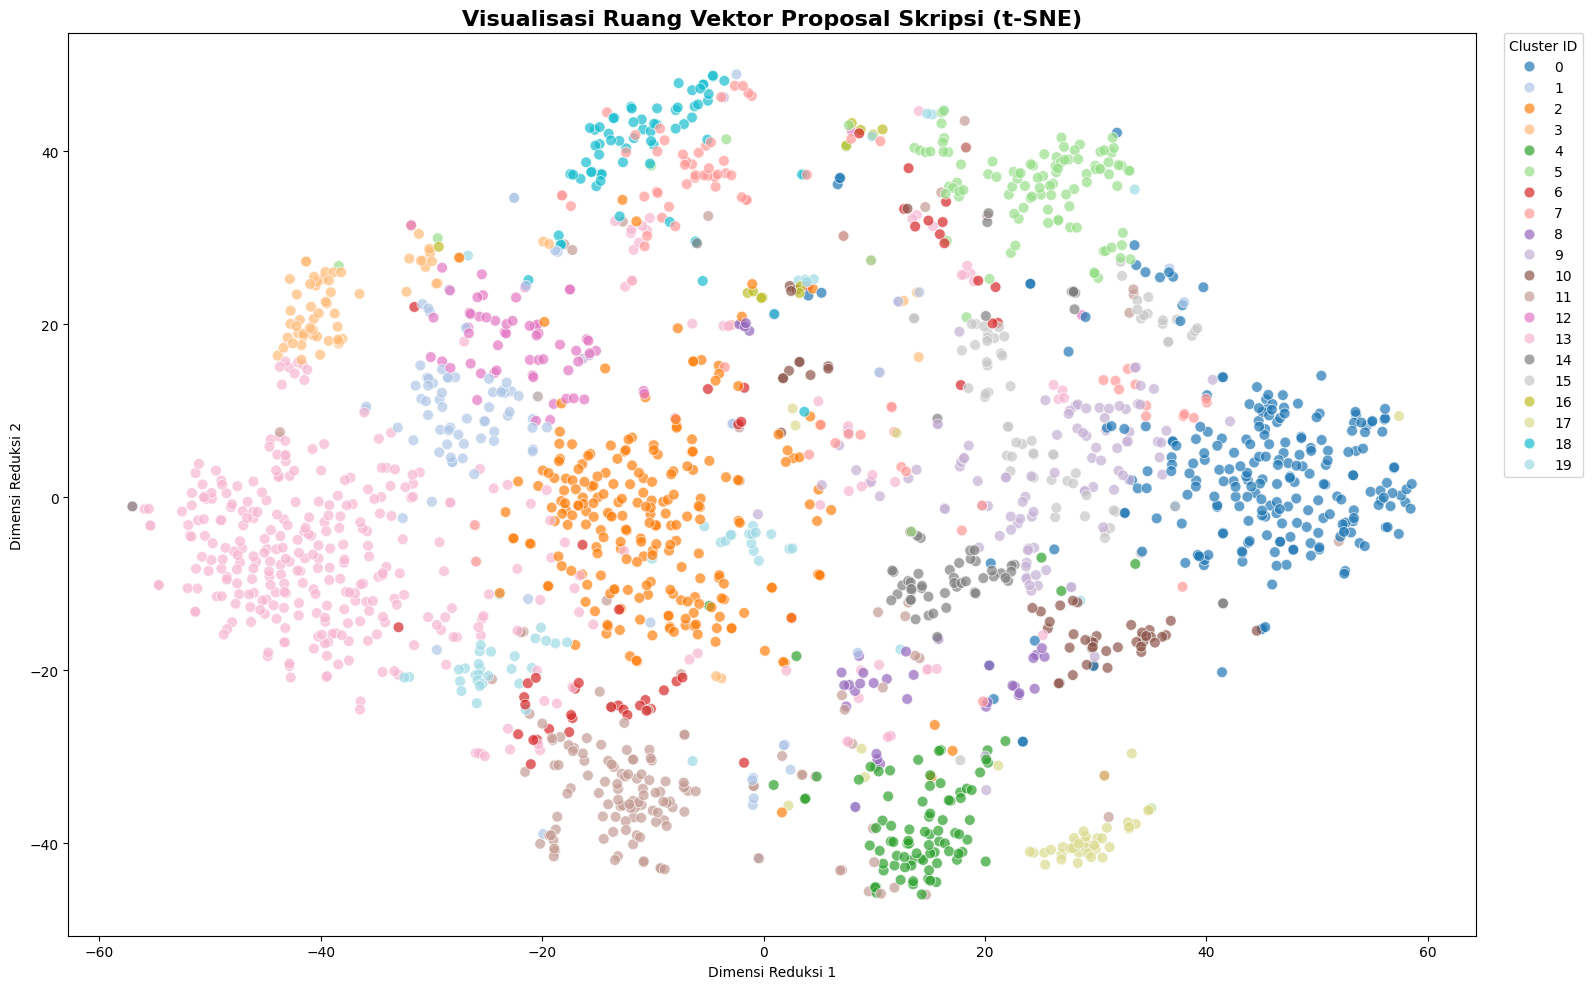

✅ Gambar tersimpan di: visualisasi_vektor_proposal.png


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pickle
import os
from sentence_transformers import SentenceTransformer

# --- KONFIGURASI PATH ---
BASE_DIR = r"D:\Media\Kuliah\Skripsi\ScripTI\Versi 4\Index_and_Clusters"
META_FILE = os.path.join(BASE_DIR, "proposal_metadata.pkl")
CLUSTER_MODEL_FILE = os.path.join(BASE_DIR, "topic_cluster_model.pkl") # Kita butuh ini
MODEL_PATH = r"D:\Media\Kuliah\Skripsi\ScripTI\Versi 4\Model\Trained_SBERT\finetuned_all-nusabert-base_v1"

def generate_visualization():
    print("⏳ Memuat data dan model...")
    
    # 1. Load Data
    if not os.path.exists(META_FILE):
        print(f"❌ File metadata tidak ditemukan: {META_FILE}")
        return
        
    df = pd.read_pickle(META_FILE)
    
    # Ambil sampel (maks 2000 biar t-SNE tidak lemot)
    if len(df) > 2000:
        df_sample = df.sample(2000, random_state=42).copy()
    else:
        df_sample = df.copy()
    
    print(f"📊 Menggunakan {len(df_sample)} sampel data...")
    
    # 2. Load Model SBERT & KMeans
    print("🧠 Memuat Model AI...")
    model = SentenceTransformer(MODEL_PATH)
    
    if not os.path.exists(CLUSTER_MODEL_FILE):
        print(f"❌ Model cluster tidak ditemukan: {CLUSTER_MODEL_FILE}")
        return

    with open(CLUSTER_MODEL_FILE, 'rb') as f:
        kmeans = pickle.load(f)

    # 3. Encode ke Vektor (768 Dimensi)
    sentences = df_sample['text'].tolist()
    print("⚡ Sedang meng-encode vektor...")
    # Cek prefix E5
    if "e5" in MODEL_PATH.lower():
        sentences = ["query: " + s for s in sentences]
        
    embeddings = model.encode(sentences, show_progress_bar=True)
    
    # 4. PREDIKSI CLUSTER (Ini langkah perbaikan!)
    # Kita prediksi label cluster secara on-the-fly
    print("🏷️  Memprediksi label cluster...")
    cluster_labels = kmeans.predict(embeddings)
    df_sample['cluster_label'] = cluster_labels # Masukkan ke DataFrame

    # 5. Reduksi Dimensi dengan t-SNE (768 -> 2 Dimensi)
    print("📉 Sedang menjalankan t-SNE (mengubah ke 2D)...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
    vectors_2d = tsne.fit_transform(embeddings)
    
    # 6. Siapkan Data Plotting
    df_sample['x'] = vectors_2d[:, 0]
    df_sample['y'] = vectors_2d[:, 1]
    
    print("🎨 Sedang menggambar grafik...")
    plt.figure(figsize=(16, 10))
    
    # Plot Scatter
    scatter = sns.scatterplot(
        data=df_sample,
        x='x', 
        y='y', 
        hue='cluster_label', # Sekarang kolom ini sudah ada!
        palette='tab20',     
        legend='full',
        alpha=0.7,
        s=60                 # Ukuran titik
    )
    
    plt.title('Visualisasi Ruang Vektor Proposal Skripsi (t-SNE)', fontsize=16, fontweight='bold')
    plt.xlabel('Dimensi Reduksi 1')
    plt.ylabel('Dimensi Reduksi 2')
    
    # Rapikan legenda
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Cluster ID', borderaxespad=0)
    plt.tight_layout()
    
    # Simpan
    output_img = "visualisasi_vektor_proposal.png"
    plt.savefig(output_img, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Gambar tersimpan di: {output_img}")

if __name__ == "__main__":
    generate_visualization()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pickle
import os
import json
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

# --- KONFIGURASI PATH ---
BASE_DIR = r"D:\Media\Kuliah\Skripsi\ScripTI\Versi 4\Index_and_Clusters"
META_FILE = os.path.join(BASE_DIR, "proposal_metadata.pkl")
CLUSTER_MODEL_FILE = os.path.join(BASE_DIR, "topic_cluster_model.pkl")
CLUSTER_INFO_FILE = os.path.join(BASE_DIR, "cluster_info_complete.json") # File JSON baru kamu
MODEL_PATH = r"D:\Media\Kuliah\Skripsi\ScripTI\Versi 4\Model\Trained_SBERT\finetuned_all-nusabert-base_v1"

def generate_visualization():
    print("⏳ Memuat data...")
    
    # 1. Load Data
    if not os.path.exists(META_FILE) or not os.path.exists(CLUSTER_INFO_FILE):
        print("❌ File data tidak lengkap.")
        return
        
    df = pd.read_pickle(META_FILE)
    
    with open(CLUSTER_INFO_FILE, 'r') as f:
        cluster_info = json.load(f)
    
    # Sampling (Max 2500 titik agar tidak terlalu padat)
    if len(df) > 2500:
        df_sample = df.sample(2500, random_state=42).copy()
    else:
        df_sample = df.copy()
    
    print(f"📊 Memproses {len(df_sample)} sampel proposal...")

    # 2. Load Model SBERT & KMeans untuk labeling ulang (Safety)
    print("🧠 Memuat Model...")
    model = SentenceTransformer(MODEL_PATH)
    with open(CLUSTER_MODEL_FILE, 'rb') as f:
        kmeans = pickle.load(f)

    # 3. Encoding & Clustering
    sentences = df_sample['text'].tolist()
    if "e5" in MODEL_PATH.lower():
        sentences = ["query: " + s for s in sentences]
        
    print("⚡ Encoding vectors...")
    embeddings = model.encode(sentences, show_progress_bar=True)
    
    print("🏷️  Clustering...")
    labels = kmeans.predict(embeddings)
    df_sample['cluster_id'] = labels

    # 4. MEMBUAT LABEL LEGENDA DARI JSON
    # Format: "Android, Game (152)"
    def get_label_name(cluster_id):
        cid = str(cluster_id)
        if cid in cluster_info:
            info = cluster_info[cid]
            name = info.get('name', f'Cluster {cid}')
            count = info.get('count', '?')
            # Ambil 2 kata kunci pertama saja biar tidak kepanjangan di gambar
            short_name = ",".join(name.split(",")[:2]) 
            return f"{short_name} ({count})"
        return f"Cluster {cid}"

    df_sample['Topik'] = df_sample['cluster_id'].apply(get_label_name)

    # 5. t-SNE Reduction
    print("📉 Menjalankan t-SNE (Dimensi 768 -> 2)...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
    vectors_2d = tsne.fit_transform(embeddings)
    
    df_sample['x'] = vectors_2d[:, 0]
    df_sample['y'] = vectors_2d[:, 1]
    
    # 6. Plotting
    print("🎨 Menggambar grafik...")
    plt.figure(figsize=(20, 12)) # Ukuran Besar
    
    # Scatter Plot dengan Warna Topik
    sns.scatterplot(
        data=df_sample,
        x='x', 
        y='y', 
        hue='Topik',   # Gunakan nama topik sebagai pembeda warna
        palette='tab20', # Palet warna kontras (20 warna)
        alpha=0.7,
        s=80,          # Ukuran titik
        edgecolor='w'
    )
    
    plt.title('Peta Sebaran Topik Proposal Skripsi (t-SNE)', fontsize=20, fontweight='bold', pad=20)
    plt.xlabel('Dimensi Semantik 1', fontsize=12)
    plt.ylabel('Dimensi Semantik 2', fontsize=12)
    
    # Legenda di luar grafik
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, title='Kelompok Topik (Jumlah Data)', fontsize=10)
    plt.tight_layout()
    
    # Simpan
    output_img = "peta_topik_final.png"
    plt.savefig(output_img, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Gambar tersimpan: {output_img}")

if __name__ == "__main__":
    generate_visualization()

⏳ Memuat data...
📊 Memproses 2500 sampel proposal...
🧠 Memuat Model...
⚡ Encoding vectors...


Batches:   0%|          | 0/79 [00:00<?, ?it/s]

⏳ Memuat data...
📊 Menggunakan 2000 sampel data.

🧠 [1/3] Memuat SBERT untuk menentukan Label Topik...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]


🧠 [2/3] Memuat Base Model 'D:\Media\Kuliah\Skripsi\ScripTI\Versi 4\Model\hf_models\LazarusNLP__all-nusabert-base-v4'...
⚡ Encoding dengan Base Model (Tanpa Fine-Tuning)...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]


📉 [3/3] Menjalankan t-SNE untuk kedua model...
🎨 Menggambar Plot Perbandingan...


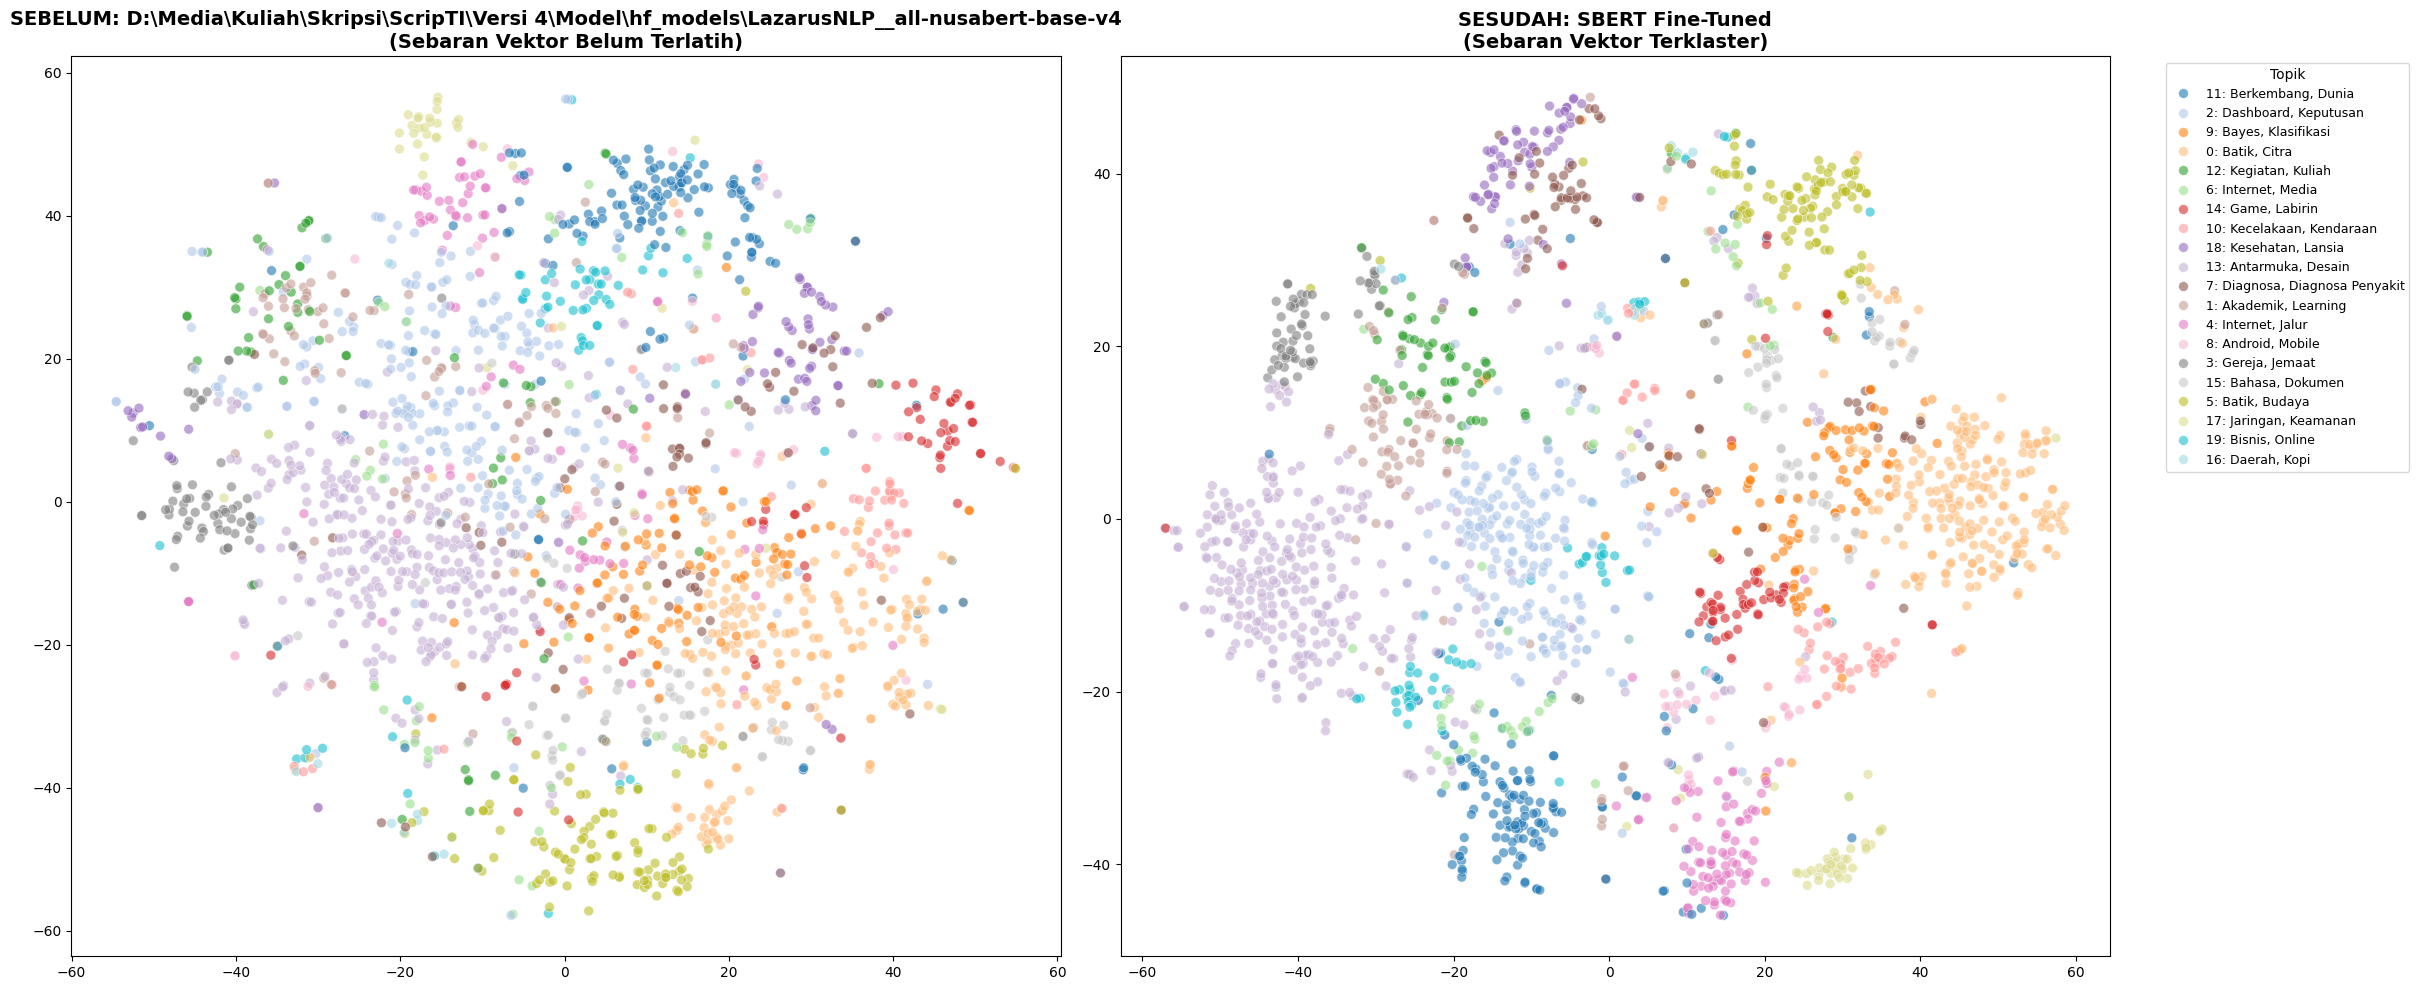

✅ Gambar Perbandingan tersimpan: perbandingan_bert_vs_sbert.png


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pickle
import os
import json
from sentence_transformers import SentenceTransformer

# --- KONFIGURASI PATH ---
BASE_DIR = r"D:\Media\Kuliah\Skripsi\ScripTI\Versi 4\Index_and_Clusters"
META_FILE = os.path.join(BASE_DIR, "proposal_metadata.pkl")
CLUSTER_INFO_FILE = os.path.join(BASE_DIR, "cluster_info_complete.json")

# MODEL SBERT ANDA (Untuk ambil Label Kebenaran)
PATH_SBERT = r"D:\Media\Kuliah\Skripsi\ScripTI\Versi 4\Model\Trained_SBERT\finetuned_all-nusabert-base_v1"
PATH_KMEANS = os.path.join(BASE_DIR, "topic_cluster_model.pkl")

# MODEL BASELINE (Pilih salah satu, misal NusaBERT Base original)
# Jika belum didownload, dia akan download otomatis dari HuggingFace (perlu internet)
BASE_MODEL_NAME = "D:\Media\Kuliah\Skripsi\ScripTI\Versi 4\Model\hf_models\LazarusNLP__all-nusabert-base-v4" 

def generate_comparison():
    print("⏳ Memuat data...")
    if not os.path.exists(META_FILE):
        print("❌ Metadata tidak ditemukan.")
        return

    df = pd.read_pickle(META_FILE)
    
    # Sampling agar adil dan cepat (2000 data)
    if len(df) > 2000:
        df_sample = df.sample(2000, random_state=42).copy()
    else:
        df_sample = df.copy()
    
    sentences = df_sample['text'].tolist()
    print(f"📊 Menggunakan {len(sentences)} sampel data.")

    # ---------------------------------------------------------
    # TAHAP 1: DAPATKAN LABEL TOPIK DARI SBERT (GROUND TRUTH)
    # ---------------------------------------------------------
    print("\n🧠 [1/3] Memuat SBERT untuk menentukan Label Topik...")
    model_sbert = SentenceTransformer(PATH_SBERT)
    emb_sbert = model_sbert.encode(sentences, show_progress_bar=True)
    
    # Load KMeans SBERT
    with open(PATH_KMEANS, 'rb') as f:
        kmeans = pickle.load(f)
    
    # Prediksi Label (Warna)
    labels = kmeans.predict(emb_sbert)
    df_sample['cluster_id'] = labels
    
    # Load Nama Topik Cantik
    with open(CLUSTER_INFO_FILE, 'r') as f:
        cluster_info = json.load(f)

    def get_label_name(cid):
        info = cluster_info.get(str(cid), {})
        name = info.get('name', f'C{cid}')
        # Ambil 2 kata pertama saja biar rapi
        short = ",".join(name.split(",")[:2])
        return f"{cid}: {short}"

    df_sample['Label'] = df_sample['cluster_id'].apply(get_label_name)

    # ---------------------------------------------------------
    # TAHAP 2: ENCODE PAKAI BASE MODEL (BERT BIASA)
    # ---------------------------------------------------------
    print(f"\n🧠 [2/3] Memuat Base Model '{BASE_MODEL_NAME}'...")
    # SentenceTransformer bisa load model HuggingFace biasa dan otomatis pakai Mean Pooling
    model_base = SentenceTransformer(BASE_MODEL_NAME)
    
    print("⚡ Encoding dengan Base Model (Tanpa Fine-Tuning)...")
    emb_base = model_base.encode(sentences, show_progress_bar=True)

    # ---------------------------------------------------------
    # TAHAP 3: VISUALISASI PERBANDINGAN
    # ---------------------------------------------------------
    print("\n📉 [3/3] Menjalankan t-SNE untuk kedua model...")
    
    # Setup t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
    
    # 1. t-SNE untuk SBERT (Sudah Bagus)
    vec_sbert_2d = tsne.fit_transform(emb_sbert)
    df_sample['x_sbert'] = vec_sbert_2d[:, 0]
    df_sample['y_sbert'] = vec_sbert_2d[:, 1]
    
    # 2. t-SNE untuk Base BERT (Belum Bagus)
    vec_base_2d = tsne.fit_transform(emb_base)
    df_sample['x_base'] = vec_base_2d[:, 0]
    df_sample['y_base'] = vec_base_2d[:, 1]

    print("🎨 Menggambar Plot Perbandingan...")
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))

    # Plot 1: Base Model (Sebelum)
    sns.scatterplot(
        ax=axes[0], data=df_sample, x='x_base', y='y_base', 
        hue='Label', palette='tab20', alpha=0.6, s=50, legend=False
    )
    axes[0].set_title(f"SEBELUM: {BASE_MODEL_NAME}\n(Sebaran Vektor Belum Terlatih)", fontsize=14, fontweight='bold')
    axes[0].set_xlabel("")
    axes[0].set_ylabel("")

    # Plot 2: SBERT (Sesudah)
    sns.scatterplot(
        ax=axes[1], data=df_sample, x='x_sbert', y='y_sbert', 
        hue='Label', palette='tab20', alpha=0.6, s=50
    )
    axes[1].set_title("SESUDAH: SBERT Fine-Tuned\n(Sebaran Vektor Terklaster)", fontsize=14, fontweight='bold')
    axes[1].set_xlabel("")
    axes[1].set_ylabel("")
    
    # Legenda di kanan luar
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Topik', fontsize=9)
    plt.tight_layout()

    output_img = "perbandingan_bert_vs_sbert.png"
    plt.savefig(output_img, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Gambar Perbandingan tersimpan: {output_img}")

if __name__ == "__main__":
    generate_comparison()

🚀 Memulai Eksperimen Visualisasi...

1. Memproses Model Dasar (D:\Media\Kuliah\Skripsi\ScripTI\Versi 4\Model\hf_models\LazarusNLP__all-nusabert-base-v4)...

2. Memproses Model Fine-Tuned (SBERT)...


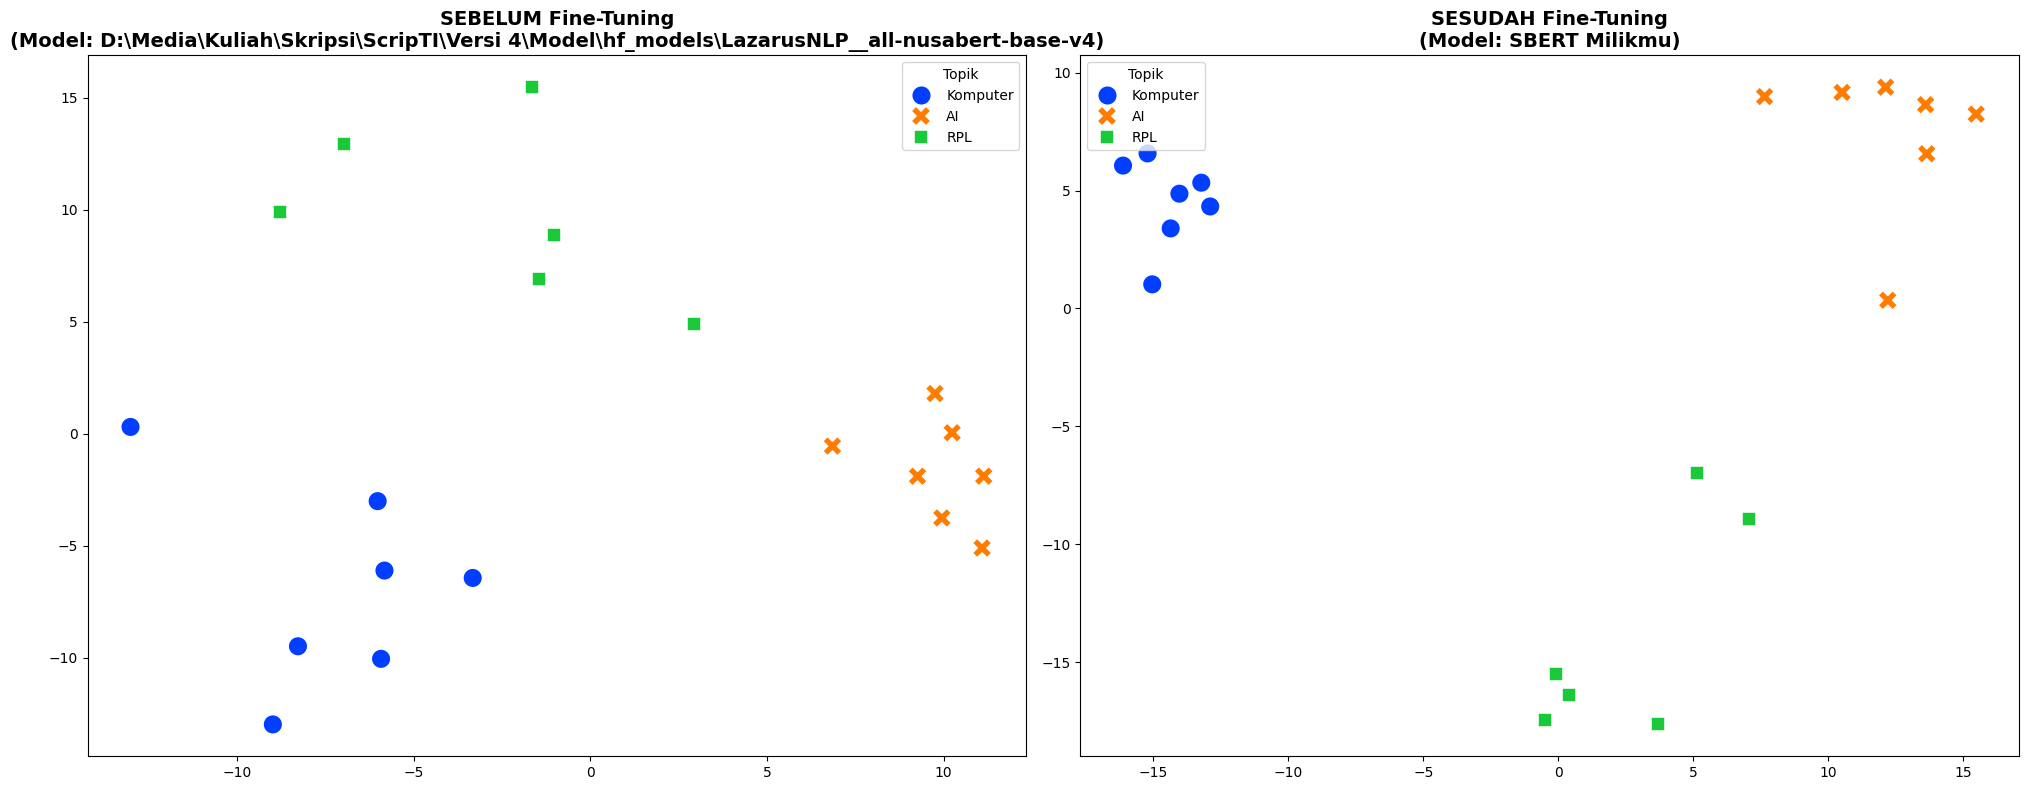


✅ Gambar perbandingan tersimpan di: bukti_perbedaan_model.png


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

# --- 1. DEFINISI DATA BUATAN (HARDCODED) ---
# Kita buat kalimat yang topiknya jelas tapi kosakatanya mungkin mirip-mirip
# --- 1. DEFINISI DATA "JEBAKAN" (HARD CASES) ---
# Semua kalimat dirancang agar membingungkan model dasar
# --- 1. DEFINISI DATA "JEBAKAN" (HARD CASES) ---
# Semua kalimat dirancang agar membingungkan model dasar
data_custom = [
    # Topik A: Jaringan Komputer (Infrastruktur / Hardware)
    {"text": "Analisis keamanan jaringan komputer menggunakan firewall.", "label": "Komputer"},
    {"text": "Konfigurasi router Mikrotik pada jaringan lokal (LAN).", "label": "Komputer"},
    {"text": "Optimasi bandwidth jaringan nirkabel di gedung universitas.", "label": "Komputer"},
    {"text": "Implementasi topologi jaringan mesh untuk desa tertinggal.", "label": "Komputer"},
    {"text": "Monitoring trafik jaringan menggunakan Wireshark.", "label": "Komputer"},
    {"text": "Rancang bangun infrastruktur server dan jaringan kantor.", "label": "Komputer"},
    {"text": "Analisis performa protokol TCP/IP pada jaringan.", "label": "Komputer"},

    # Topik B: Jaringan Syaraf Tiruan (AI / Algoritma)
    {"text": "Prediksi harga saham menggunakan Jaringan Syaraf Tiruan.", "label": "AI"},
    {"text": "Implementasi algoritma Backpropagation pada jaringan syaraf.", "label": "AI"},
    {"text": "Klasifikasi citra menggunakan Convolutional Neural Network.", "label": "AI"},
    {"text": "Optimasi bobot jaringan syaraf dengan algoritma Genetika.", "label": "AI"},
    {"text": "Pelatihan model jaringan syaraf untuk deteksi pola tulisan.", "label": "AI"},
    {"text": "Analisis akurasi Artificial Neural Network pada data medis.", "label": "AI"},
    {"text": "Penerapan Deep Learning pada jaringan syaraf berulang (RNN).", "label": "AI"},

    # Topik C: Rekayasa Perangkat Lunak (RPL - Pembanding)
    {"text": "Rancang bangun sistem informasi akademik berbasis web.", "label": "RPL"},
    {"text": "Pengembangan aplikasi e-commerce menggunakan React Native.", "label": "RPL"},
    {"text": "Analisis UI/UX pada aplikasi mobile banking.", "label": "RPL"},
    {"text": "Sistem pendukung keputusan pemilihan karyawan terbaik.", "label": "RPL"},
    {"text": "Implementasi metode Waterfall pada pengembangan sistem.", "label": "RPL"},
    {"text": "Pembuatan website profil perusahaan menggunakan Laravel.", "label": "RPL"},
]
df = pd.DataFrame(data_custom)
sentences = df['text'].tolist()

# --- 2. KONFIGURASI MODEL ---
# Ganti path ini dengan path model SBERT fine-tuned milikmu
PATH_SBERT_FINETUNED = r"D:\Media\Kuliah\Skripsi\ScripTI\Versi 4\Model\Trained_SBERT\finetuned_all-nusabert-base_v1"

# Model Base (Asli dari HuggingFace)
BASE_MODEL_NAME = "D:\Media\Kuliah\Skripsi\ScripTI\Versi 4\Model\hf_models\LazarusNLP__all-nusabert-base-v4" 

def run_comparison():
    print("🚀 Memulai Eksperimen Visualisasi...")
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # --- MODEL 1: BASE (SEBELUM) ---
    print(f"\n1. Memproses Model Dasar ({BASE_MODEL_NAME})...")
    model_base = SentenceTransformer(BASE_MODEL_NAME)
    emb_base = model_base.encode(sentences)
    
    # Gunakan PCA karena datanya sedikit (lebih stabil daripada t-SNE untuk data kecil)
    pca_base = PCA(n_components=2)
    vec_base = pca_base.fit_transform(emb_base)
    
    sns.scatterplot(
        ax=axes[0], x=vec_base[:,0], y=vec_base[:,1], 
        hue=df['label'], style=df['label'], s=200, palette='bright'
    )
    axes[0].set_title(f"SEBELUM Fine-Tuning\n(Model: {BASE_MODEL_NAME})", fontsize=14, fontweight='bold')
    axes[0].legend(title='Topik')

    # --- MODEL 2: SBERT (SESUDAH) ---
    print(f"\n2. Memproses Model Fine-Tuned (SBERT)...")
    model_sbert = SentenceTransformer(PATH_SBERT_FINETUNED)
    emb_sbert = model_sbert.encode(sentences)
    
    pca_sbert = PCA(n_components=2)
    vec_sbert = pca_sbert.fit_transform(emb_sbert)
    
    sns.scatterplot(
        ax=axes[1], x=vec_sbert[:,0], y=vec_sbert[:,1], 
        hue=df['label'], style=df['label'], s=200, palette='bright'
    )
    axes[1].set_title("SESUDAH Fine-Tuning\n(Model: SBERT Milikmu)", fontsize=14, fontweight='bold')
    axes[1].legend(title='Topik')

    plt.tight_layout()
    output_file = "bukti_perbedaan_model.png"
    plt.savefig(output_file, dpi=300)
    plt.show()
    print(f"\n✅ Gambar perbandingan tersimpan di: {output_file}")

if __name__ == "__main__":
    run_comparison()

⏳ Memuat data...
🔍 Memfilter data hanya untuk klaster: [0, 14, 18, 19, 16]...
🧠 Menggunakan SBERT untuk memfilter topik...


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

📊 Total data terpilih untuk visualisasi: 670 proposal

⚡ Encoding dengan Base Model (D:\Media\Kuliah\Skripsi\ScripTI\Versi 4\Model\hf_models\LazarusNLP__all-nusabert-base-v4)...


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

⚡ Encoding dengan SBERT Fine-Tuned...


Batches:   0%|          | 0/21 [00:00<?, ?it/s]


📉 Menjalankan t-SNE...
🎨 Menggambar Grafik Perbandingan...


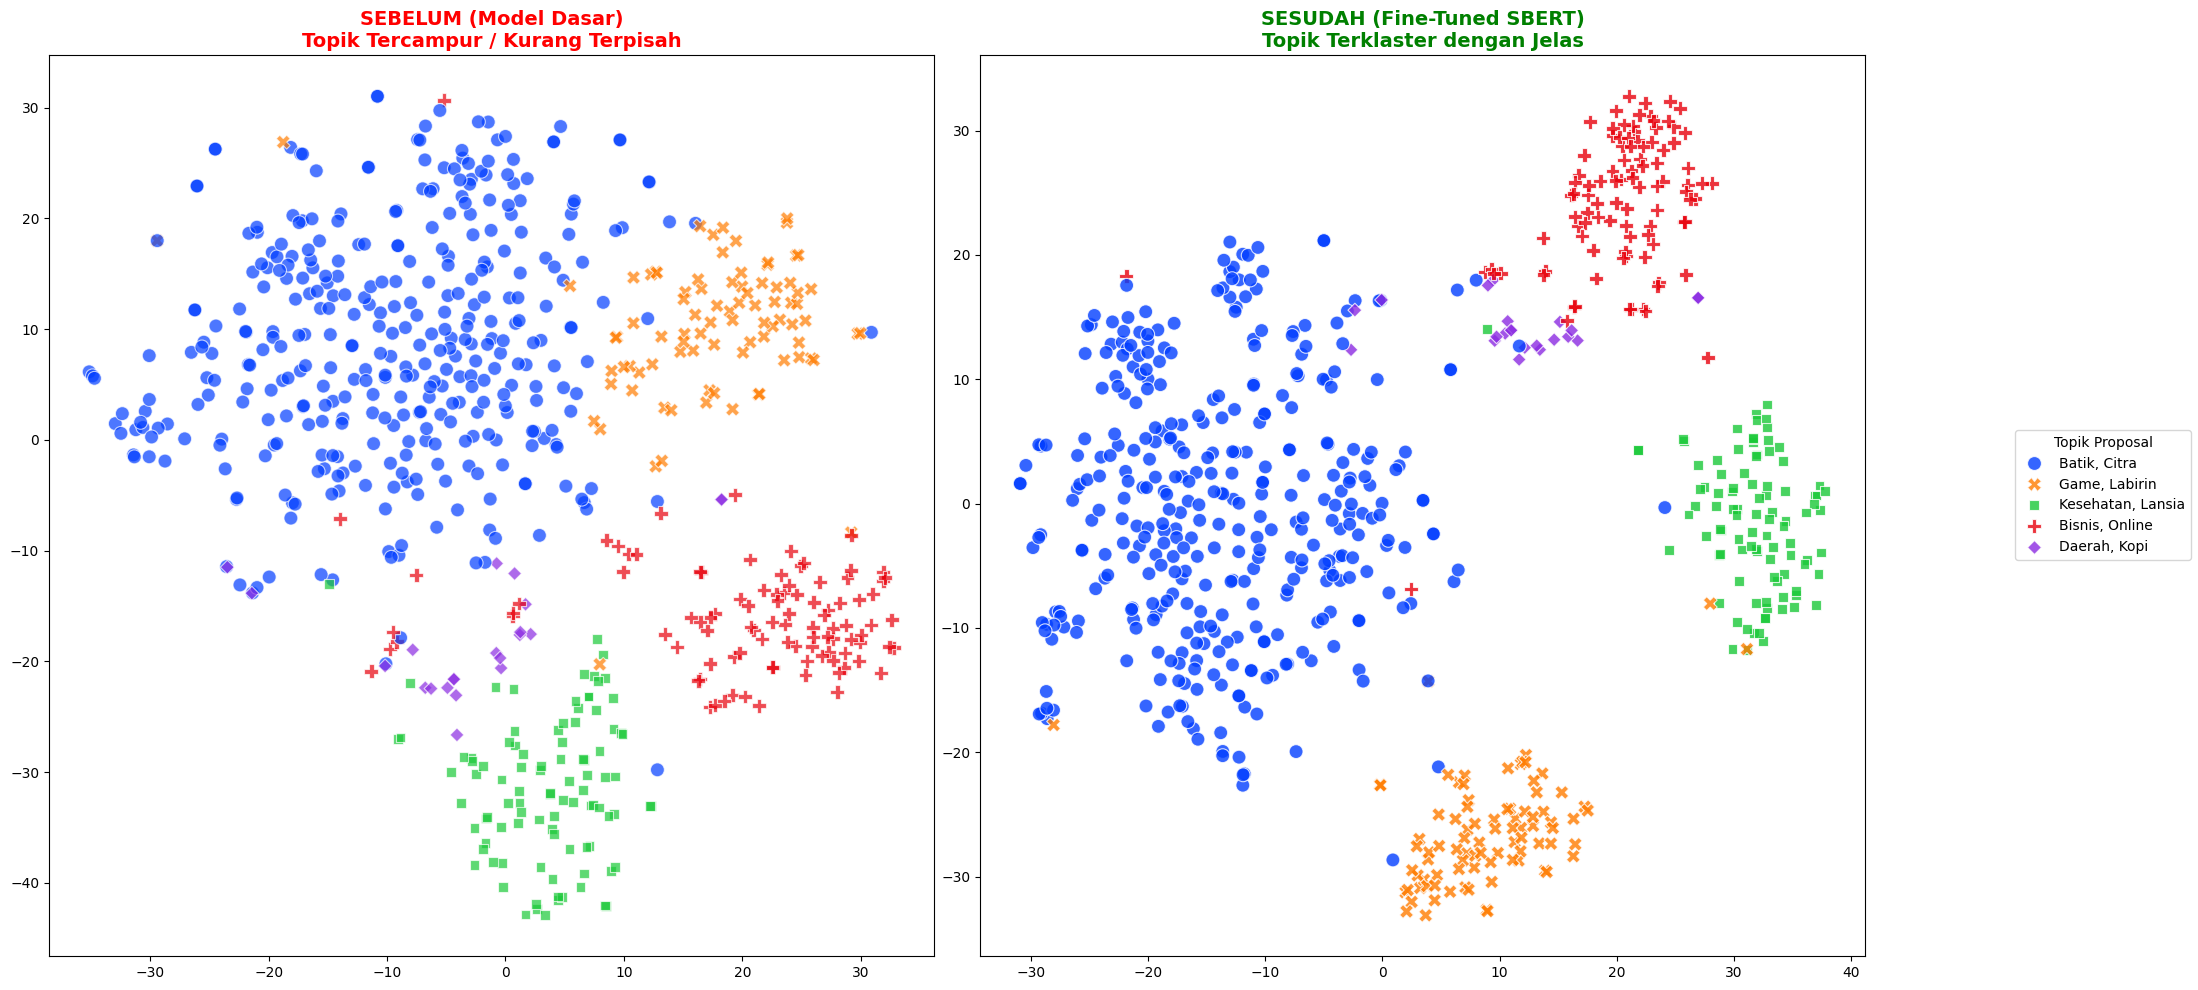

✅ Gambar selesai: perbandingan_clean_5_topik.png


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pickle
import os
import json
from sentence_transformers import SentenceTransformer

# --- KONFIGURASI PATH ---
BASE_DIR = r"D:\Media\Kuliah\Skripsi\ScripTI\Versi 4\Index_and_Clusters"
META_FILE = os.path.join(BASE_DIR, "proposal_metadata.pkl")
CLUSTER_INFO_FILE = os.path.join(BASE_DIR, "cluster_info_complete.json")

# MODEL (Ganti path sesuai milikmu)
PATH_SBERT = r"D:\Media\Kuliah\Skripsi\ScripTI\Versi 4\Model\Trained_SBERT\finetuned_all-nusabert-base_v1"
BASE_MODEL_NAME = "D:\Media\Kuliah\Skripsi\ScripTI\Versi 4\Model\hf_models\LazarusNLP__all-nusabert-base-v4" 

# --- PILIH 5 KLASTER YANG INGIN DITAMPILKAN ---
# (Sesuaikan ID ini dengan JSON kamu yang bagus tadi)
# Contoh dari data sebelumnya:
# 0: Batik, Citra
# 14: Internet, Jaringan
# 18: Android, Smartphone
# 19: Game, Pembelajaran
# 16: Pertanian, Sampah
SELECTED_CLUSTERS = [0, 14, 18, 19, 16]

def generate_clean_comparison():
    print("⏳ Memuat data...")
    if not os.path.exists(META_FILE) or not os.path.exists(CLUSTER_INFO_FILE):
        print("❌ File data tidak lengkap.")
        return

    # 1. Load Data & Info
    df = pd.read_pickle(META_FILE)
    
    with open(CLUSTER_INFO_FILE, 'r') as f:
        cluster_info = json.load(f)
        
    # Helper untuk dapat nama topik
    def get_topic_name(cid):
        cid_str = str(cid)
        if cid_str in cluster_info:
            raw_name = cluster_info[cid_str].get('name', f'Cluster {cid}')
            # Ambil 2 kata pertama biar pendek di legenda
            return ",".join(raw_name.split(",")[:2])
        return f"Cluster {cid}"

    # 2. Filter Hanya 5 Klaster Terpilih
    print(f"🔍 Memfilter data hanya untuk klaster: {SELECTED_CLUSTERS}...")
    
    # Kita perlu label cluster asli dulu.
    # Asumsi: df di pickle belum punya label cluster terbaru dari re-index terakhir.
    # Jadi kita load model KMeans untuk melabeli ulang semua data dulu (cepat kok).
    
    PATH_KMEANS = os.path.join(BASE_DIR, "topic_cluster_model.pkl")
    with open(PATH_KMEANS, 'rb') as f:
        kmeans = pickle.load(f)
        
    # Kita butuh encode sebentar pakai SBERT untuk dapat label klaster yang akurat
    print("🧠 Menggunakan SBERT untuk memfilter topik...")
    model_sbert = SentenceTransformer(PATH_SBERT)
    
    # Encode semua (atau sample besar) untuk filtering
    # Ambil 3000 sample biar cepat, lalu filter
    if len(df) > 3000:
        df_pool = df.sample(3000, random_state=42).copy()
    else:
        df_pool = df.copy()
        
    sentences_pool = df_pool['text'].tolist()
    emb_pool = model_sbert.encode(sentences_pool, show_progress_bar=True)
    labels_pool = kmeans.predict(emb_pool)
    df_pool['cluster_id'] = labels_pool
    
    # AMBIL HANYA YANG MASUK 5 KLASTER PILIHAN
    df_filtered = df_pool[df_pool['cluster_id'].isin(SELECTED_CLUSTERS)].copy()
    
    # Beri Nama Label Cantik
    df_filtered['Label'] = df_filtered['cluster_id'].apply(get_topic_name)
    
    print(f"📊 Total data terpilih untuk visualisasi: {len(df_filtered)} proposal")
    sentences_final = df_filtered['text'].tolist()

    # ---------------------------------------------------------
    # TAHAP 3: BANDINGKAN DUA MODEL
    # ---------------------------------------------------------
    
    # A. Encode dengan BASE MODEL (Sebelum)
    print(f"\n⚡ Encoding dengan Base Model ({BASE_MODEL_NAME})...")
    model_base = SentenceTransformer(BASE_MODEL_NAME)
    emb_base = model_base.encode(sentences_final, show_progress_bar=True)
    
    # B. Encode dengan SBERT (Sesudah) - pake yg tadi udah dihitung sebagian
    # Tapi biar urutannya pas sama df_filtered, kita encode ulang aja yang filtered
    print(f"⚡ Encoding dengan SBERT Fine-Tuned...")
    emb_sbert = model_sbert.encode(sentences_final, show_progress_bar=True)

    # ---------------------------------------------------------
    # TAHAP 4: t-SNE & PLOTTING
    # ---------------------------------------------------------
    print("\n📉 Menjalankan t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
    
    # Transform Base
    vec_base = tsne.fit_transform(emb_base)
    df_filtered['x_base'] = vec_base[:, 0]
    df_filtered['y_base'] = vec_base[:, 1]
    
    # Transform SBERT
    vec_sbert = tsne.fit_transform(emb_sbert)
    df_filtered['x_sbert'] = vec_sbert[:, 0]
    df_filtered['y_sbert'] = vec_sbert[:, 1]

    print("🎨 Menggambar Grafik Perbandingan...")
    fig, axes = plt.subplots(1, 2, figsize=(22, 10))
    
    # Plot 1: Sebelum
    sns.scatterplot(
        ax=axes[0], data=df_filtered, x='x_base', y='y_base', 
        hue='Label', style='Label', palette='bright', s=100, alpha=0.7
    )
    axes[0].set_title("SEBELUM (Model Dasar)\nTopik Tercampur / Kurang Terpisah", fontsize=14, fontweight='bold', color='red')
    axes[0].get_legend().remove() # Hapus legenda biar gak penuh
    axes[0].set_xlabel("")
    axes[0].set_ylabel("")

    # Plot 2: Sesudah
    sns.scatterplot(
        ax=axes[1], data=df_filtered, x='x_sbert', y='y_sbert', 
        hue='Label', style='Label', palette='bright', s=100, alpha=0.8
    )
    axes[1].set_title("SESUDAH (Fine-Tuned SBERT)\nTopik Terklaster dengan Jelas", fontsize=14, fontweight='bold', color='green')
    axes[1].set_xlabel("")
    axes[1].set_ylabel("")
    
    # Legenda Bersama
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', title="Topik Proposal")
    axes[1].get_legend().remove()
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.85) # Beri ruang untuk legenda di kanan
    
    output_img = "perbandingan_clean_5_topik.png"
    plt.savefig(output_img, dpi=300)
    plt.show()
    print(f"✅ Gambar selesai: {output_img}")

if __name__ == "__main__":
    generate_clean_comparison()

In [1]:
from transformers import AutoModel
from sentence_transformers import SentenceTransformer

# 1. MODEL LAMA (BERT Murni / Pre-trained)
# Ini model mentah dari HuggingFace (sebelum Anda fine-tune)
print("="*50)
print("ARSITEKTUR 1: BERT STANDAR (PRE-TRAINED)")
print("="*50)
bert_model = AutoModel.from_pretrained("D:\Media\Kuliah\Skripsi\ScripTI\Versi 4\Model\hf_models\LazarusNLP__all-nusabert-base-v4" )
print(bert_model)

print("\n" + "="*50)
print("ARSITEKTUR 2: SBERT (SETELAH FINE-TUNING)")
print("="*50)

# 2. MODEL BARU (SBERT Milik Anda)
# Ganti path ini ke model hasil training Anda
PATH_SBERT = r"D:\Media\Kuliah\Skripsi\ScripTI\Versi 4\Model\Trained_SBERT\finetuned_all-nusabert-base_v1"
sbert_model = SentenceTransformer(PATH_SBERT)
print(sbert_model)

ARSITEKTUR 1: BERT STANDAR (PRE-TRAINED)
BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(32032, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          

In [1]:
import torch
from sentence_transformers import SentenceTransformer
from torchviz import make_dot
import os

# --- 1. KONFIGURASI PATH MODEL ---
# Ganti dengan path model SBERT hasil training Anda
MODEL_PATH = r"D:\Media\Kuliah\Skripsi\ScripTI\Versi 4\Model\Trained_SBERT\finetuned_all-nusabert-base_v1"

# --- 2. FUNGSI VISUALISASI ---
def generate_torchviz_graph():
    print("⏳ Memuat model...")
    try:
        model = SentenceTransformer(MODEL_PATH)
    except Exception as e:
        print(f"❌ Gagal memuat model: {e}")
        return

    # Buat Data Dummy (Pura-pura ada input proposal)
    dummy_text = ["Analisis sistem informasi berbasis Android."]
    
    # Tokenisasi manual agar kita dapat Tensor (Input untuk Torchviz)
    # SBERT membungkus tokenizer di dalamnya
    print("⚡ Menyiapkan input dummy...")
    features = model.tokenize(dummy_text)
    
    # Pindahkan ke device yang sama (CPU/GPU)
    device = model.device
    features = {k: v.to(device) for k, v in features.items()}

    # Lakukan Forward Pass (Jalankan data melewati model)
    print("🧠 Melakukan Forward Pass untuk melacak alur data...")
    
    # Output dari SBERT biasanya adalah dictionary {'sentence_embedding': ...}
    output = model(features)
    
    # Ambil vektor hasil akhirnya (Sentence Embedding)
    embedding_tensor = output['sentence_embedding']

    # --- 3. GAMBAR GRAFIK DENGAN TORCHVIZ ---
    print("🎨 Menggambar grafik (ini mungkin memakan waktu)...")
    
    # make_dot akan menelusuri riwayat tensor ke belakang
    graph = make_dot(
        embedding_tensor, 
        params=dict(model.named_parameters()),
        show_attrs=True,
        show_saved=True
    )
    
    # Beri nama file output
    output_filename = "arsitektur_sbert_flow"
    
    # Simpan ke PDF dan PNG
    try:
        graph.format = 'png'
        graph.render(output_filename)
        print(f"✅ Gambar tersimpan: {output_filename}.png")
        
        graph.format = 'pdf'
        graph.render(output_filename)
        print(f"✅ PDF tersimpan: {output_filename}.pdf (Lebih detail jika di-zoom)")
        
    except Exception as e:
        print("\n❌ ERROR SAAT MENYIMPAN GAMBAR!")
        print("Kemungkinan besar 'Graphviz' belum terinstall di Windows Anda.")
        print("Solusi: Download installer Graphviz dari https://graphviz.org/download/")
        print("Pastikan centang 'Add to PATH' saat install.")
        print(f"Detail Error: {e}")

if __name__ == "__main__":
    generate_torchviz_graph()

⏳ Memuat model...
⚡ Menyiapkan input dummy...
🧠 Melakukan Forward Pass untuk melacak alur data...
🎨 Menggambar grafik (ini mungkin memakan waktu)...


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.906945 to fit


✅ Gambar tersimpan: arsitektur_sbert_flow.png
✅ PDF tersimpan: arsitektur_sbert_flow.pdf (Lebih detail jika di-zoom)


In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
from torchviz import make_dot
import os

# --- 1. KONFIGURASI PATH ---
# Path Model Awal (BERT Biasa / Base)
PATH_BASE_MODEL = r"D:\Media\Kuliah\Skripsi\ScripTI\Versi 4\Model\hf_models\LazarusNLP__all-nusabert-base-v4"

# Path Model Akhir (SBERT Fine-Tuned)
PATH_SBERT_MODEL = r"D:\Media\Kuliah\Skripsi\ScripTI\Versi 4\Model\Trained_SBERT\finetuned_all-nusabert-base_v1"

# Dummy Input
TEXT_INPUT = ["Analisis deteksi kemiripan proposal skripsi."]

def visualize_base_bert():
    print(f"\n[1/2] Sedang memvisualisasikan BASE MODEL: {os.path.basename(PATH_BASE_MODEL)}...")
    try:
        # Load sebagai AutoModel (HuggingFace Transformers murni)
        # Ini akan menampilkan struktur asli BERT tanpa layer tambahan SBERT
        model = AutoModel.from_pretrained(PATH_BASE_MODEL)
        tokenizer = AutoTokenizer.from_pretrained(PATH_BASE_MODEL)
        
        # Siapkan Input
        inputs = tokenizer(TEXT_INPUT, return_tensors="pt")
        
        # Forward Pass
        outputs = model(**inputs)
        
        # Kita ambil 'last_hidden_state' (Output utama BERT)
        # Ini bentuknya (Batch, Sequence Length, 768) -> Belum di-pooling
        target_tensor = outputs.last_hidden_state
        
        # Gambar Grafik
        graph = make_dot(target_tensor, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
        graph.format = 'pdf'
        graph.render("arsitektur_base_bert")
        print("✅ Berhasil! File tersimpan: arsitektur_base_bert.pdf")
        
    except Exception as e:
        print(f"❌ Gagal memproses Base Model: {e}")

def visualize_sbert():
    print(f"\n[2/2] Sedang memvisualisasikan SBERT MODEL: {os.path.basename(PATH_SBERT_MODEL)}...")
    try:
        # Load sebagai SentenceTransformer
        # Ini akan menampilkan struktur BERT + POOLING Layer
        model = SentenceTransformer(PATH_SBERT_MODEL)
        
        # Tokenisasi (SBERT menangani ini secara internal, tapi kita butuh tensor manual buat torchviz)
        features = model.tokenize(TEXT_INPUT)
        features = {k: v.to(model.device) for k, v in features.items()}
        
        # Forward Pass
        output = model(features)
        
        # Kita ambil 'sentence_embedding' (Output akhir SBERT)
        # Ini bentuknya (Batch, 768) -> SUDAH di-pooling
        target_tensor = output['sentence_embedding']
        
        # Gambar Grafik
        graph = make_dot(target_tensor, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
        graph.format = 'pdf'
        graph.render("arsitektur_sbert_finetuned")
        print("✅ Berhasil! File tersimpan: arsitektur_sbert_finetuned.pdf")
        
    except Exception as e:
        print(f"❌ Gagal memproses SBERT Model: {e}")

if __name__ == "__main__":
    print("🚀 Memulai Generasi Grafik Arsitektur...")
    visualize_base_bert()
    visualize_sbert()
    print("\n🏁 Selesai. Silakan cek folder proyek Anda.")